In [1]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import config
from scipy.io import loadmat

plt.style.use('seaborn-v0_8')

In [2]:
import numpy as np

def plot_endmembers_estimation(ee:dict, n_endmembers:int, ticks_range:tuple=(0, 1), n_ticks:int=5):
    '''
        Plot the endmembers estimated by the different algorithms
        
        Parameters
        ----------
            ee: dict
                Dictionary containing the endmembers estimated by the different algorithms.

            n_endmembers: int
                Number of endmembers to plot.

            ticks_range: tuple
                Range of the y axis ticks.

            n_ticks: int
                Number of ticks to plot on the y axis.
    '''
      
    endmembers_labels = list(map(lambda x: f'$E_{x}$', np.arange(n_endmembers) + 1))
    y_ticks_formatter = plt.FormatStrFormatter('%.1f')


    with plt.style.context(("seaborn-colorblind")):
        fig, ax = plt.subplots(1, len(ee.keys()), figsize=(15, 3))
        ticks = np.linspace(*ticks_range, n_ticks)
        for i, (eea, em) in enumerate(ee.items()):
                ax[i].plot(em.T, label=endmembers_labels)
                ax[i].set_title(eea, fontsize='large')
                ax[i].set_yticks(ticks)
                ax[i].set_yticklabels([])           
                ax[i].set_ylim(ticks_range[0] - 0.025, ticks_range[1] + 0.025)

        ax[0].set_ylabel("Reflectance", fontsize='x-large')
        ax[0].set_yticklabels(y_ticks_formatter.format_ticks(ticks))
        
        # Introduce a general X axis label
        fig.add_subplot(111, frameon=False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.xlabel("Bands", fontsize='x-large')
        plt.yticks([])  
        
        plt.tight_layout()

        #include a legend for the endmembers
        handles, labels = ax[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower center', ncol=5, fontsize='large')

    return fig

In [3]:
def show_abundance_estimation(method:str, ae:dict, n_endmembers:int, figsize=(8,10)):
    '''
        Plot the abundance estimation results for the different algorithms

        Parameters
        ----------
            method: str
                Name of the algorithm used for abundance estimation.

            ae: dict
                Dictionary containing the abundance estimation results for the different algorithms.

            n_endmembers: int
                Number of endmembers to plot.
    '''
    eea_labels = ae.keys()
    with plt.style.context(("seaborn-colorblind")):
        fig, ax = plt.subplots(len(eea_labels), n_endmembers, figsize=figsize)
        for i, eea in enumerate(eea_labels):
            for j in range(n_endmembers):
                im = ax[i,j].imshow(ae[eea][method][:,:,j].T, cmap='viridis')
                ax[i,j].set_xticks([])
                ax[i,j].set_yticks([])
                fig.colorbar(im, ax=ax[i,j], orientation='horizontal', fraction=0.046, pad=0.04)

            ax[i,0].set_ylabel(f'{eea}', fontsize='x-large')
            for j in range(n_endmembers):
                ax[0,j].set_title(f'$E_{j+1}$', fontsize='x-large')

            # title of the figure
            fig.suptitle(f'Abundance estimation - {method}', fontsize='xx-large')

        plt.tight_layout()
    
    return fig 

# Jasper Ridge

In [ ]:
from dataset import JasperRidge
dataset = JasperRidge(config.JasperRidge_PATH)

In [ ]:
# read data from matlab
results_dir = os.path.join(config.RESULTS_PATH, 'matlab/dataset/jasper')
files = os.listdir(results_dir)
matlab_files = sorted(list(map(lambda x: os.path.join(results_dir, x), files)))
print(matlab_files)
from scipy.io import loadmat
matlab_data = loadmat(matlab_files[0])
matlab_data.keys()

In [ ]:
from HySpecLab.metrics import sad

eea_labels = ['ATGP', 'AVMAX', 'NFINDR', 'PPI', 'VCA']
ab_methods = ['abFclsM', 'abNnlsM', 'abUclsM']

endmember_estimation = {}
abundance_estimation = {}

for i, eea in enumerate(eea_labels):
    matlab_data = loadmat(matlab_files[i])
    _endmember = matlab_data['em'].T
    sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
    idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth

    # check if idx values are unique
    if len(idx) != len(torch.unique(idx)):
        print('idx is not unique')
        # check where is repeated and change it for the second one
        for j in range(len(idx)):
            if len(torch.where(idx == idx[j])[0]) > 1:
                idx[j] = torch.where(idx == idx[j])[0][1]
        
    print(idx)
    endmember_estimation[eea] = _endmember[idx]

    # abundance estimation
    abundance = {}
    for ab_method in ab_methods:
        A = matlab_data[ab_method].astype(np.float32)
        A = A[:,:,idx]
        
        abundance[ab_method] = A

    abundance_estimation[eea] = abundance


In [ ]:
imgs_dir = os.path.join(config.RESULTS_PATH, 'matlab/imgs/jasper')
fig = plot_endmembers_estimation(endmember_estimation, dataset.n_endmembers, ticks_range=(0, .8))
fig.savefig(os.path.join(imgs_dir, 'endmembers_estimation.pdf'), bbox_inches='tight')

plt.show()

In [ ]:
methods = abundance_estimation['PPI'].keys()
n_endmembers = dataset.n_endmembers

for method in methods:
    fig = show_abundance_estimation(method, abundance_estimation, n_endmembers)
    fig.savefig(os.path.join(imgs_dir, f'abundance_estimation_{method}.png'), bbox_inches='tight', dpi=300)
    plt.show()


# Samson

In [ ]:
from dataset import Samson
dataset = Samson(config.Samson_PATH)

In [ ]:
# read data from matlab
results_dir = os.path.join(config.RESULTS_PATH, 'matlab/dataset/samson')
files = os.listdir(results_dir)
matlab_files = sorted(list(map(lambda x: os.path.join(results_dir, x), files)))

# from scipy.io import loadmat
# matlab_data = loadmat(matlab_files[0])
# matlab_data.keys()

In [ ]:
from HySpecLab.metrics import sad

eea_labels = ['ATGP', 'AVMAX', 'NFINDR', 'PPI', 'VCA']
ab_methods = ['abFclsM', 'abNnlsM', 'abUclsM']

endmember_estimation = {}
abundance_estimation = {}

for i, eea in enumerate(eea_labels):
    matlab_data = loadmat(matlab_files[i])
    _endmember = matlab_data['em'].T
    sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
    idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth

    # check if idx values are unique
    if len(idx) != len(torch.unique(idx)):
        print('idx is not unique')
        # check where is repeated and change it for the second one
        for j in range(len(idx)):
            if len(torch.where(idx == idx[j])[0]) > 1:
                idx[j] = torch.where(idx == idx[j])[0][1]
        
    print(idx)
    endmember_estimation[eea] = _endmember[idx]

    # abundance estimation
    abundance = {}
    for ab_method in ab_methods:
        A = matlab_data[ab_method].astype(np.float32)
        A = A[:,:,idx]
        
        abundance[ab_method] = A

    abundance_estimation[eea] = abundance

In [ ]:
imgs_dir = os.path.join(config.RESULTS_PATH, 'matlab/imgs/samson')
fig = plot_endmembers_estimation(endmember_estimation, dataset.n_endmembers)
fig.savefig(os.path.join(imgs_dir, 'endmembers_estimation.pdf'), bbox_inches='tight')

plt.show()

In [ ]:
methods = abundance_estimation['PPI'].keys()
n_endmembers = dataset.n_endmembers

for method in methods:
    fig = show_abundance_estimation(method, abundance_estimation, n_endmembers)
    fig.savefig(os.path.join(imgs_dir, f'abundance_estimation_{method}.png'), bbox_inches='tight', dpi=300)
    plt.show()

# Urban

In [4]:
from dataset import Urban
dataset = Urban(config.Urban_PATH)

results_dir = os.path.join(config.RESULTS_PATH, 'matlab/dataset/urban')
files = os.listdir(results_dir)
matlab_files = sorted(list(map(lambda x: os.path.join(results_dir, x), files)))

In [22]:
from HySpecLab.metrics import sad

eea_labels = ['ATGP', 'AVMAX', 'NFINDR', 'PPI', 'VCA']
ab_methods = ['abFclsM', 'abNnlsM', 'abUclsM']

endmember_estimation = {}
abundance_estimation = {}

# ATGP
eea = eea_labels[0]
matlab_data = loadmat(matlab_files[0])
_endmember = matlab_data['em'].T
sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
# print(sad_result)
# print(idx)
idx[1] = 3
# print(idx)
endmember_estimation[eea] = _endmember[idx]
# abundance estimation
abundance = {}
for ab_method in ab_methods:
    A = matlab_data[ab_method].astype(np.float32)
    A = A[:,:,idx]
    
    abundance[ab_method] = A

abundance_estimation[eea] = abundance

# AVMAX
eea = eea_labels[1]
matlab_data = loadmat(matlab_files[1])
_endmember = matlab_data['em'].T
sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
# print(sad_result)
# print(idx)
idx[1] = 1
# print(idx)
endmember_estimation[eea] = _endmember[idx]
# abundance estimation
abundance = {}
for ab_method in ab_methods:
    A = matlab_data[ab_method].astype(np.float32)
    A = A[:,:,idx]
    
    abundance[ab_method] = A

abundance_estimation[eea] = abundance

# NFINDR
eea = eea_labels[2]
matlab_data = loadmat(matlab_files[2])
_endmember = matlab_data['em'].T
sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
# print(sad_result)
# print(idx)
idx[1] = 0
endmember_estimation[eea] = _endmember[idx]
# abundance estimation
abundance = {}
for ab_method in ab_methods:
    A = matlab_data[ab_method].astype(np.float32)
    A = A[:,:,idx]
    
    abundance[ab_method] = A

abundance_estimation[eea] = abundance

# PPI
eea = eea_labels[3]
matlab_data = loadmat(matlab_files[3])
_endmember = matlab_data['em'].T
sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
# print(sad_result)
# print(idx)
idx[1] = 1
idx[2] = 2
# print(idx)

endmember_estimation[eea] = _endmember[idx]
# abundance estimation
abundance = {}
for ab_method in ab_methods:
    A = matlab_data[ab_method].astype(np.float32)
    A = A[:,:,idx]
    
    abundance[ab_method] = A

abundance_estimation[eea] = abundance


# VCA
eea = eea_labels[4]
matlab_data = loadmat(matlab_files[4])
_endmember = matlab_data['em'].T
sad_result = sad(dataset.endmembers(), torch.tensor(_endmember).float())
idx = torch.argmin(sad_result, dim=1) # Index for reordering the ground truth
# print(sad_result)
# print(idx)
idx[1] = 3
endmember_estimation[eea] = _endmember[idx]
# abundance estimation
abundance = {}
for ab_method in ab_methods:
    A = matlab_data[ab_method].astype(np.float32)
    A = A[:,:,idx]
    
    abundance[ab_method] = A

abundance_estimation[eea] = abundance


In [19]:
_endmember = matlab_data['em'].T
_endmember.shape

(4, 162)

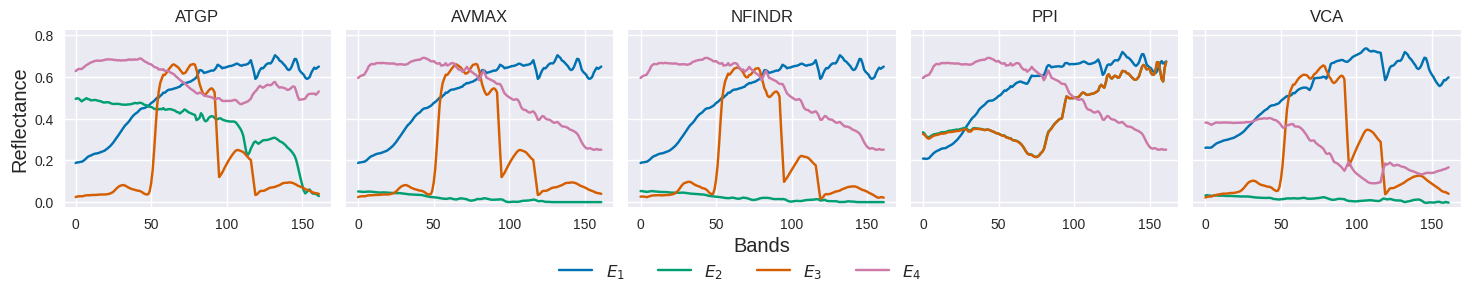

In [23]:
imgs_dir = os.path.join(config.RESULTS_PATH, 'matlab/imgs/urban')
fig = plot_endmembers_estimation(endmember_estimation, dataset.n_endmembers, ticks_range=(0, .8), n_ticks=5)
fig.savefig(os.path.join(imgs_dir, 'endmembers_estimation.pdf'), bbox_inches='tight')

plt.show()

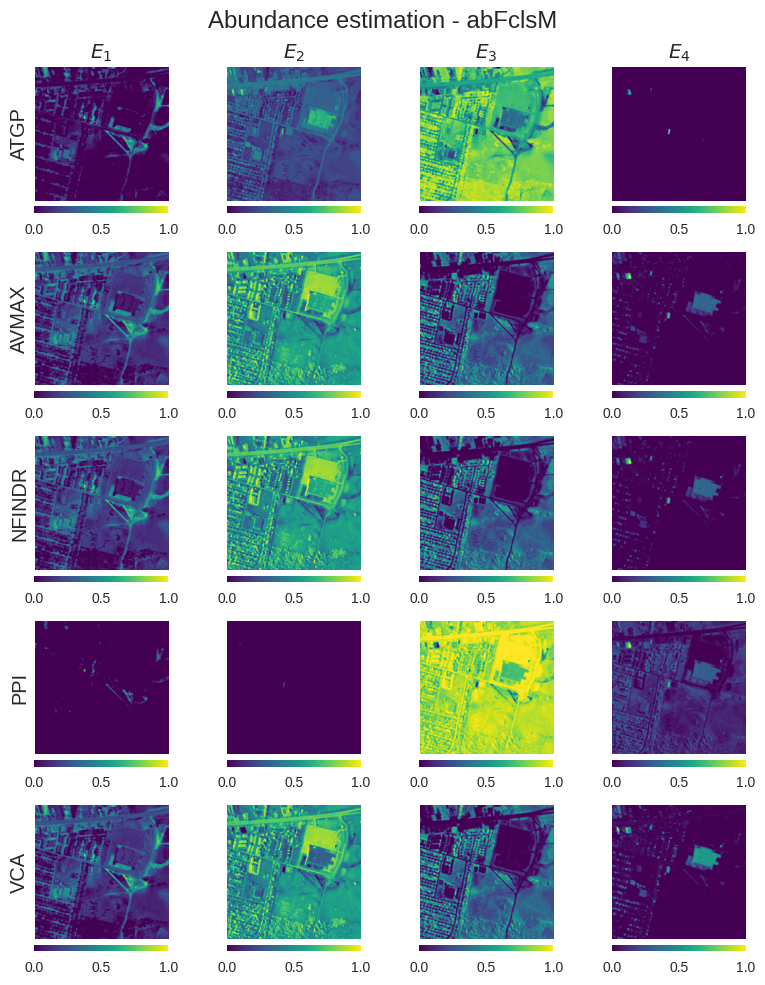

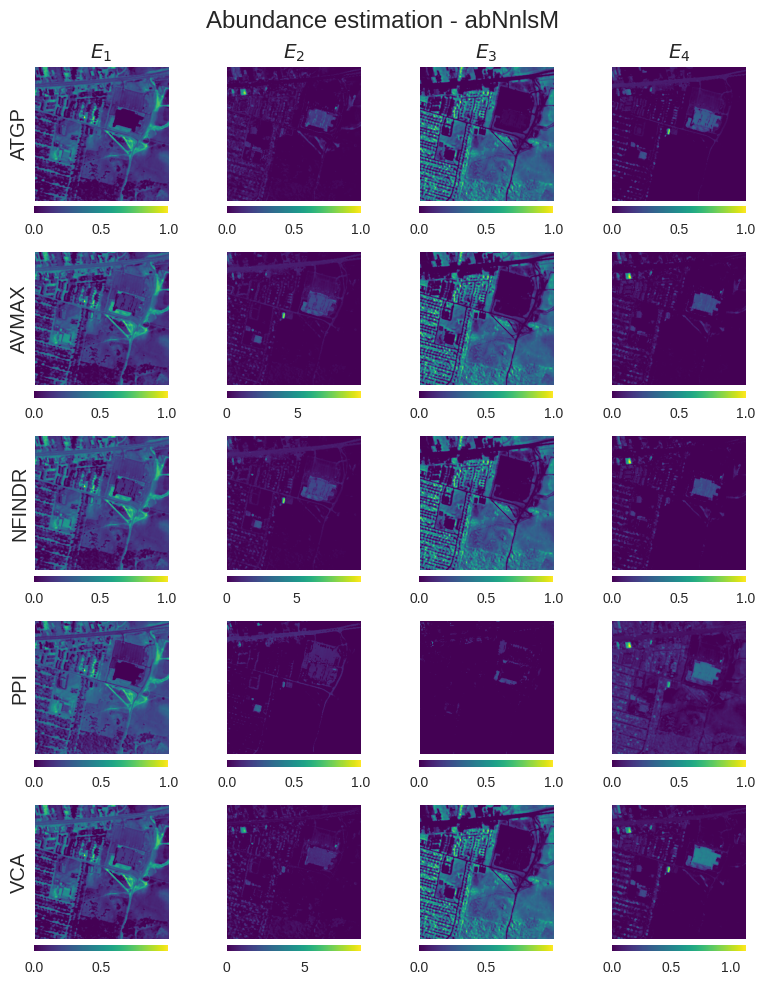

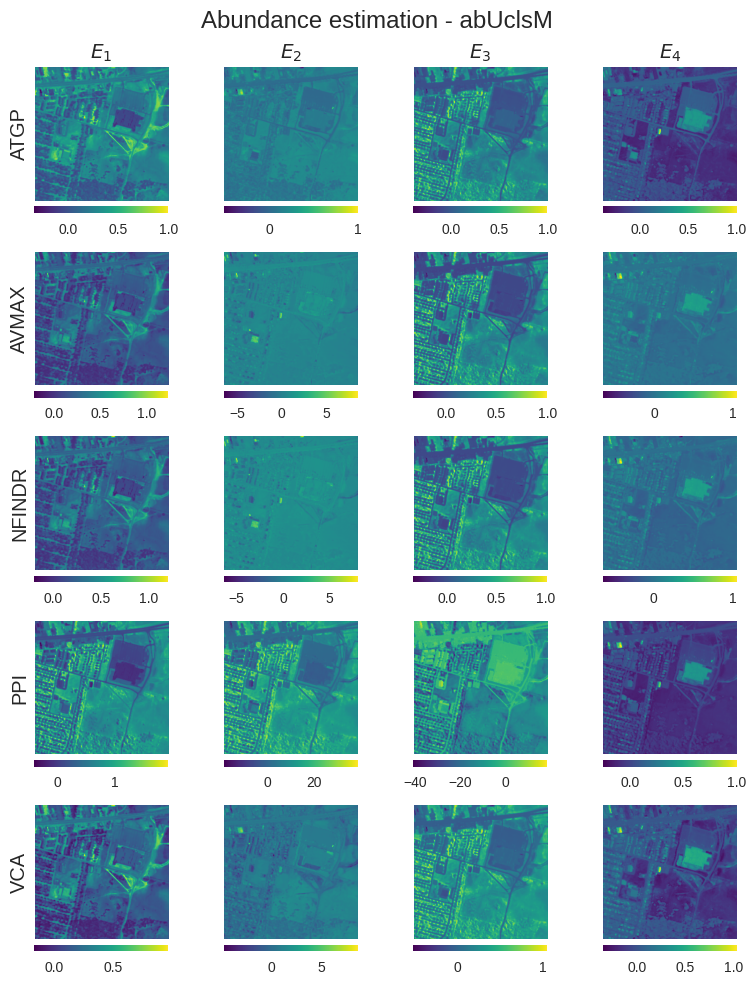

In [25]:
methods = abundance_estimation['PPI'].keys()
n_endmembers = dataset.n_endmembers

for method in methods:
    fig = show_abundance_estimation(method, abundance_estimation, n_endmembers)
    fig.savefig(os.path.join(imgs_dir, f'abundance_estimation_{method}.png'), bbox_inches='tight', dpi=300)
    plt.show()

# Urban End4